# 🔥 Subword Transformer Language Model (LLM) - Local Training Solution

This notebook demonstrates how to build a subword-level Transformer-based language model using:
- SentencePiece (BPE Tokenizer)
- PyTorch transformer stack
- Top-k and Top-p sampling
- WikiText-style corpus

✅ Ideal for:
- Learning LLM internals
- Testing model configs on small data
- Building from scratch before moving to Hugging Face

*By [Rajesh Singh](https://www.kaggle.com/rajinh)*


## Import Packages & Set Device

In [9]:
import os, math, torch
import torch.nn as nn
import torch.nn.functional as F
import sentencepiece as spm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Using device:', device)



Using device: mps


## Load Dataset and Train Tokenizer

In [12]:
# Download WikiText-103
ds = load_dataset("wikitext", "wikitext-103-raw-v1")
text = "\n".join(ds["train"]["text"])
with open("data/wikitext103.txt", "w") as f:
    f.write(text)

## Train SentencePiece BPE tokenizer

In [ ]:
import sentencepiece as spm
import time

start = time.time()
print("⏳ Training SentencePiece tokenizer...")

spm.SentencePieceTrainer.train(
    input='data/wikitext103.txt',
    model_prefix='wikitext_bpe',
    vocab_size=16000,
    model_type='bpe',
    character_coverage=1.0,
    input_sentence_size=200_000,
    shuffle_input_sentence=True,
    num_threads=4,
    train_extremely_large_corpus=True
)

print(f"✅ Done in {time.time() - start:.2f} seconds.")


## Load and Test Tokenizer

In [15]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load("wikitext_bpe.model")

sample = "To be or not to be"
encoded = sp.encode(sample, out_type=int)
print("Encoded:", encoded)
print("Decoded:", sp.decode(encoded))

Encoded: [1866, 103, 185, 218, 36, 103]
Decoded: To be or not to be


## Define Transformer Model (6 layers, 512-dim, attention) with Attention + Positional Encoding

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, nhead=8, nhid=1024, nlayers=6, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        encoder_layers = nn.TransformerEncoderLayer(embed_dim, nhead, nhid, dropout)
        self.transformer = nn.TransformerEncoder(encoder_layers, nlayers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self._attn_weights = []

    # def forward(self, src, return_attention=False):
    #     x = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
    #     x = self.pos_encoder(x)
    #     if return_attention:
    #         self._attn_weights = []
    #         for layer in self.transformer.layers:
    #             x = layer.self_attn(x, x, x, need_weights=True)[0]
    #             self._attn_weights.append(layer.self_attn.attn_output_weights)
    #     else:
    #         x = self.transformer(x)
    #     return self.fc_out(x)

    def forward(self, src, return_attention=False):
        x = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        x = self.pos_encoder(x)
    
        if return_attention:
            attn_weights_all = []
            for layer in self.transformer.layers:
                attn_out, attn_weights = layer.self_attn(x, x, x, need_weights=True)
                x = layer.dropout1(attn_out)
                x = layer.norm1(x + attn_out)
                x = layer.norm2(x + layer.dropout2(layer.linear2(F.relu(layer.linear1(x)))))
                attn_weights_all.append(attn_weights)
            self._attn_weights = attn_weights_all
        else:
            x = self.transformer(x)
    
        return self.fc_out(x)



## Prepare Tokenized Data and Batching

In [21]:
import os

# Try to load pre-tokenized data
if os.path.exists("data/tokenized_wikitext103.pt"):
    print("🔄 Loading pre-tokenized data...")
    data = torch.load("data/tokenized_wikitext103.pt")
else:
    print("🧪 Tokenizing from text (first-time only)...")
    tokens = []
    with open("data/wikitext103.txt") as f:
        for i, line in enumerate(f):
            if line.strip():
                tokens.extend(sp.encode(line.strip(), out_type=int))
            if i % 10000 == 0:
                print(f"Processed {i} lines...")
    data = torch.tensor(tokens, dtype=torch.long)
    torch.save(data, "data/tokenized_wikitext103.pt")


🧪 Tokenizing from text (first-time only)...
Processed 0 lines...
Processed 10000 lines...
Processed 20000 lines...
Processed 30000 lines...
Processed 40000 lines...
Processed 50000 lines...
Processed 60000 lines...
Processed 70000 lines...
Processed 80000 lines...
Processed 90000 lines...
Processed 100000 lines...
Processed 110000 lines...
Processed 120000 lines...
Processed 130000 lines...
Processed 140000 lines...
Processed 150000 lines...
Processed 160000 lines...
Processed 170000 lines...
Processed 180000 lines...
Processed 190000 lines...
Processed 200000 lines...
Processed 210000 lines...
Processed 220000 lines...
Processed 230000 lines...
Processed 240000 lines...
Processed 250000 lines...
Processed 260000 lines...
Processed 270000 lines...
Processed 280000 lines...
Processed 290000 lines...
Processed 300000 lines...
Processed 310000 lines...
Processed 320000 lines...
Processed 330000 lines...
Processed 340000 lines...
Processed 350000 lines...
Processed 360000 lines...
Processe

## Train the Model

In [24]:
block_size = 64
batch_size = 32
epochs = 1000
vocab_size = sp.get_piece_size()

model = TransformerModel(vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define get_batch
def get_batch(data, block_size, batch_size):
    ix = torch.randint(0, len(data) - block_size - 1, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

for epoch in range(epochs):
    x, y = get_batch(data, block_size, batch_size)
    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


/opt/anaconda3/envs/llm-dev/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0, Loss: 9.9326
Epoch 100, Loss: 7.2634
Epoch 200, Loss: 7.1076
Epoch 300, Loss: 6.9964
Epoch 400, Loss: 6.8847
Epoch 500, Loss: 6.7474
Epoch 600, Loss: 6.5560
Epoch 700, Loss: 6.6358
Epoch 800, Loss: 6.4738
Epoch 900, Loss: 6.5072


## Generate Text with Top-k / Top-p Sampling

In [38]:
def top_k_top_p_filtering(logits, top_k=50, top_p=0.9):
    top_k = min(top_k, logits.size(-1))
    if top_k > 0:
        top_k_vals, _ = torch.topk(logits, top_k)
        logits[logits < top_k_vals[:, -1].unsqueeze(-1)] = -float("Inf")
    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
        sorted_indices_to_remove[:, 0] = 0
        for i in range(logits.size(0)):
            logits[i, sorted_indices[i][sorted_indices_to_remove[i]]] = -float("Inf")
    return logits

def clean_output(text):
    text = text.replace(" @-@ ", "-")
    text = text.replace(" ,", ",").replace(" .", ".")
    text = text.replace(" :", ":").replace(" ;", ";")
    text = text.replace(" 's", "'s").replace(" n't", "n't")
    text = text.replace("( ", "(").replace(" )", ")")
    text = text.replace("`` ", "\"").replace(" ''", "\"")
    return text.strip()

def generate(model, sp, context_ids, max_tokens=100, temperature=1.0, top_k=40, top_p=0.95):
    model.eval()
    ids = torch.tensor(context_ids, dtype=torch.long).unsqueeze(0).to(device)
    for _ in range(max_tokens):
        with torch.no_grad():
            logits = model(ids)
            logits = logits[:, -1, :] / temperature
            logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            ids = torch.cat([ids, next_token], dim=1)
    raw_text = sp.decode(ids[0].tolist())
    return clean_output(raw_text)

prompt = "In conclusion, the results of the analysis suggest"
context_ids = sp.encode(prompt, out_type=int)

output = generate(model, sp, context_ids)
print(output)



In conclusion, the results of the analysis suggest in the first-. In the T, he in the city, and its original Din, and the first. The song's the only. The second of a, he would not-over on the F, and the E of the first game, and to do the secondith of a more s the film. While the song, it was released to the Bing on a long, and their episode's on the New which he on the Pu's, who


## Visualize Attention Weights

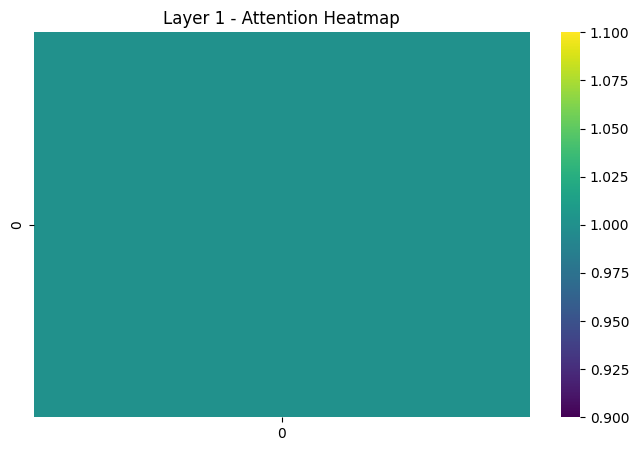

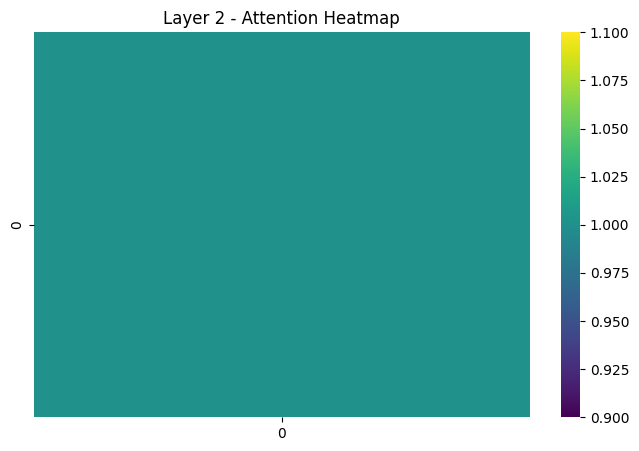

In [32]:
model.eval()
_ = model(torch.tensor(context_ids).unsqueeze(0).to(device), return_attention=True)
weights = model._attn_weights[0].squeeze().cpu().detach().numpy()

import matplotlib.pyplot as plt
import seaborn as sns

for i, w in enumerate(model._attn_weights[:2]):  # first 2 layers
    plt.figure(figsize=(8, 5))
    sns.heatmap(w[0].cpu().detach().numpy(), cmap="viridis")
    plt.title(f"Layer {i+1} - Attention Heatmap")
    plt.show()

